In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML;

# Introduction to Learning From Data

We are now beginnging to discuss how to learn from data.

The idea of learning from data is one of the most important shifts in thinking about computing to come about in the past 50 years.

Consider the commonly heard phrase:

>"Computers can only do what we tell them to do."

or

>"Computers can not create anything new.  They can only do what we already know how to do."

This line of argument goes back to Lady Ada Lovelace, often credited as the first programmer.

Working with Charles Babbage, she wrote about the Analytical Engine:

>The Analytical Engine has no pretensions whatever to originate anything. It can do whatever we know how to order it to perform. It can follow analysis; but it has no power of anticipating any analytical relations or truths.

Ada Augusta Lovelace, Commentary on "Sketch of the Analytical Engine" (1843)

However, it is clear that this viewpoint is entirely __wrong.__

All around us today, computers solve problems that humans do not know how to solve.

Computers routinely beat the world's experts in games of chess, go, etc.    They perform tasks such as facial recognition, speech synthesis, automatic language translation, and so forth.   

In each case, the programmers who wrote the programs don't themselves know how to perform these tasks.

Instead, those programmers have written programs that __learn from data.__

However, the best methods for learning from data have taken decades to develop.  

So we will spend some time now talking about the general problem of learning from data.

## The Supervised Learning Problem

The supervised learning problem in general is:
    
You are given some example data, which we'll think of abstractly as tuples $\{(\mathbf{x}_i, y_i)\,|\,i = 1,\dots,N\}$.  

Your goal is to learn a rule that allows you to predict $y_j$ for some $\mathbf{x}_j$ that is not in the example data you were given.

Typically $\mathbf{x}$ is a vector.

We use the term "features" to refer to the components of $\mathbf{x}$.

The collection $\{(\mathbf{x}_i, y_i)\,|\,i = 1,\dots,N\}$ is called the __training data.__

If $y$ is a discrete value (a label, for example) then the problem is called __classification.__

For example, in image recognition, the features $\mathbf{x}$ could be a vector that represents the pixels of the image, and $y$ could be a label such as "tiger," "tree," etc.

If $y$ is a continuous (numeric) value, then the problem is called __regression.__ 

For example, in predicting housing prices, the features $\mathbf{x}$ could be a vector containing lot size, square footage, number of bathrooms, etc., and $y$ could be the sale price of the house.

In the regression case, you will usually be satisfied if your prediction is __close__ to the true $y$ (it doesn't have to be exact to be useful).

What do we have to assume to make this problem tractable?

We assume two things:
1. There is a set of functions ("rules") that could be used to predict $y_i$ from $\mathbf{x}_i$.   This allows us to turn the learning problem into one that searches through this set for the "right" function.   However, this set is probably __very__ large!

2. The rule for predicting $y_i$ from $\mathbf{x}_i$ is the same as the rule for predicting $y_j$ from the new item $\mathbf{x}_j$. Speaking probabilistically, we say that $(\mathbf{x}_i, y_i)$ and $(\mathbf{x}_j, y_j)$ are drawn from the __same distribution.__

## A Toy Example

```{note}
The following is based on Section 1.1 of Bishop (2006).
```

In order to explore these ideas a bit, we'll use a toy example: a regression problem.

This is a very artificial example, but it will expose some important wrinkles in the supervised learning problem.

We will consider polynomial curve fitting.

Suppose we are given a training set comprising $N$ observations of a scalar value $x_i$, which we'll collect into the vector $\mathbf{x}$.  

For each $x_i$ we have a corresponding numeric value $y_i$, and these form $\mathbf{y}$.

Here is a plot of the 10 training points:

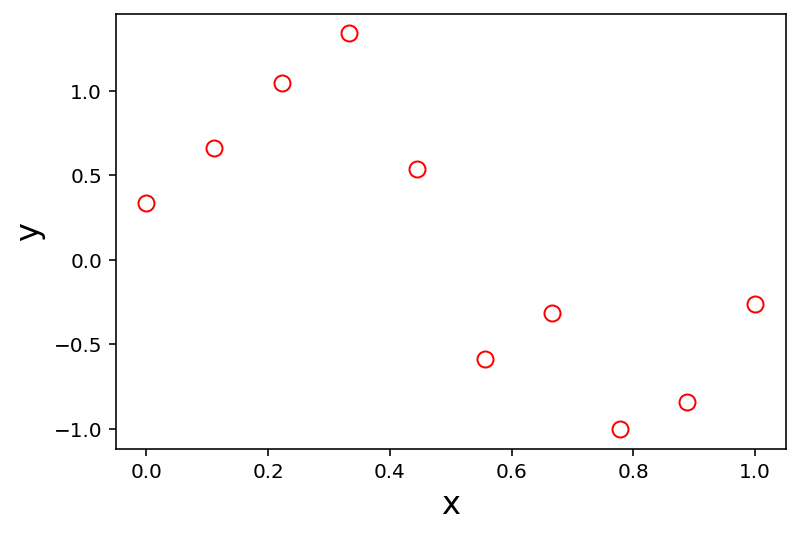

In [57]:
np.random.seed(2)
N = 10
x = np.linspace(0, 1, N)
from numpy.random import default_rng
y = np.sin(2 * np.pi * x) + default_rng().normal(size = N, scale = 0.20)
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16);

The way we generated these points was to take $\mathbf{x}$ as equal spaced points on the range 0 to 1,

and for each $x_i$, we take $y_i = \sin(2\pi x_i)$ __plus__ a sample of a Gaussian random variable.

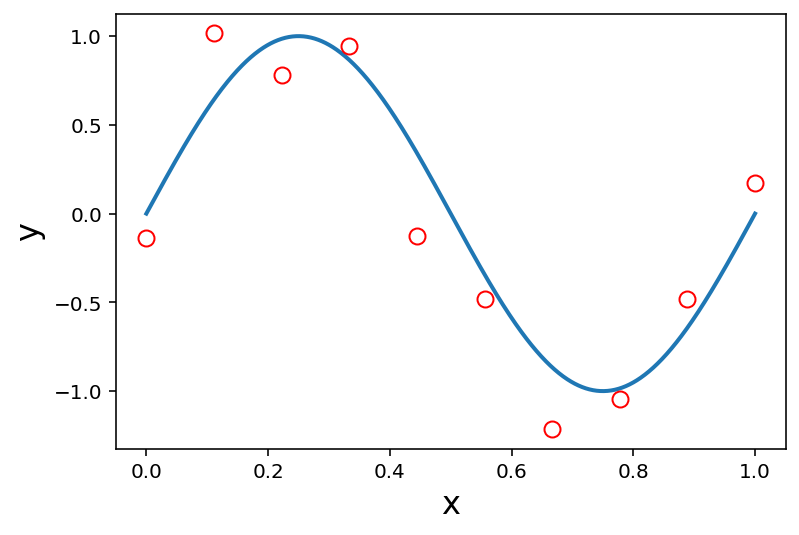

In [54]:
cx = np.linspace(0, 1, 1000)
cy = np.sin(2 * np.pi * cx)
plt.plot(cx, cy, lw = 2)
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16);

Many data sets are like this!  

In many cases, there is some component of $y$ that depends on $x$, and some component that we treat as random, called "noise."

The "noise" component is typically not __really__ random, but rather depends on features that we cannot see.

(Remember, probability is useful for exactly this case.)

Now for this toy example, we "happen" to know that the __correct__ rule to use for preduction is:
    
$$ y = \sin(2\pi x) $$

and the Gaussian random addition does not depend on $x$ so we cannot hope to predict it.

OK, let's learn from this data.

We will consider a simple approach based on curve fitting.

The class of models we will consider are polynomials.   They are of the form:

$$ y(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \dots + w_k x^k = \sum_{j = 0}^k w_jx^j $$

where $k$ is the _order_ of the polynomial.

If we are given some $k$, then what we want to learn are the $w_i$s, that is, $\mathbf{w}$.  

The $w_i$s are the __parameters__ of the model.

Note that this function $y(x, \mathbf{w})$ is a nonlinear function in $x$ ... but it is __linear__ in $\mathbf{w}$.  That is, all the $w_i$s appear only raised to the first power.   

This model is linear in its parameters -- it is called a __linear model.__

Linear models are particularly easy to fit to data.

### Model Fitting

How will we fit our model, that is, learn the best parameters $\mathbf{w}$?

We will use a objective function to guide our search through the space of model parameters.

The objective function we will use is called the __least squares criterion__:

$$ E(\mathbf{w}) = \sum_{n=1}^N [y(x_n, \mathbf{w}) - y_n]^2 $$

This is a nonnegative function which is zero if the polynomial passes through every point exactly.

We often write $\hat{y}_n$ for $y(x_n, \mathbf{w})$.

Then:

$$ E(\mathbf{w}) = \Vert \hat{\mathbf{y}} - \mathbf{y} \Vert^2. $$

In other words, the error function $E(\cdot)$ measures the distance or dissimilarity between the data and the predictions.

Finding a $\mathbf{w}$ that minimizes $E(\mathbf{w})$ is a least-squares problem, and we can solve it in closed form (details later in the course).

The resulting solution $\mathbf{w}^*$ is the set of parameters that __minimizes the error on the training data.__

### Model Selection

So we are done, correct?

Wait ... what about choosing $k$, the order of the polynomial?

The problem of choosing $k$ is called __model selection.__

That is, a polynomial of order 3 (a cubic) is a __different model__ from a polynomial of order 2 (a quadratic).

Let's look at constant (order 0), linear (order 1), and cubic (order 3) models.

We will fit each one using the least squares criterion:

In [118]:
# y = Aw, A is design matrix 1, [1, x^T], [1, x^T, x^T^2], etc, and w-hat = (A^TA)^-1 A^Ty
w_hat_0 = 1/N * np.sum(y)
A_1 = np.column_stack([np.ones(N), x.T])
w_hat_1 = np.linalg.inv(A_1.T @ A_1) @ A_1.T @ y
A_3 = np.column_stack([np.ones(N), x.T, (x.T)**2, (x.T)**3])
w_hat_3 = np.linalg.inv(A_3.T @ A_3) @ A_3.T @ y

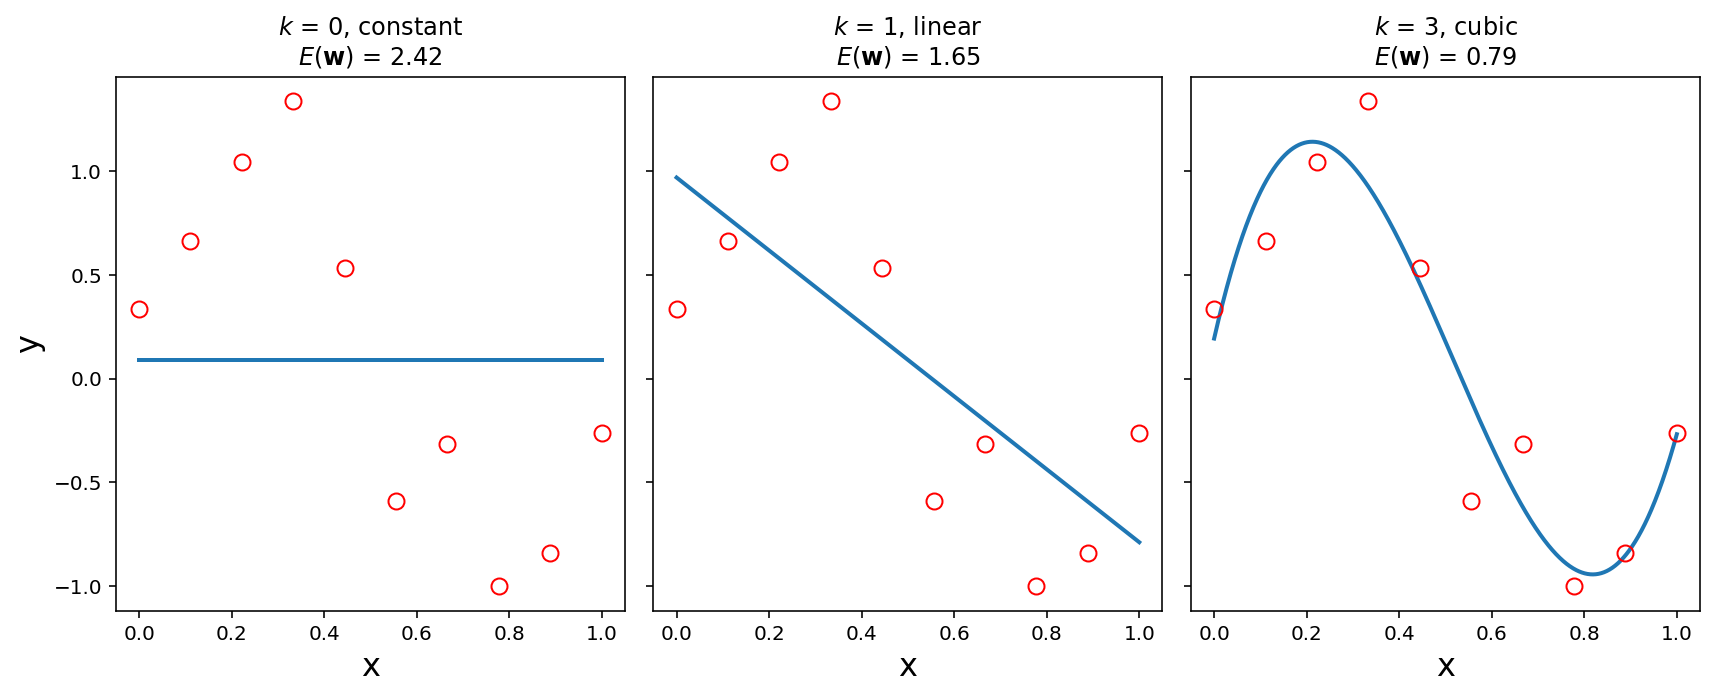

In [119]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 5))
#
cy = 1000 * [w_hat_0]
pred_y = 10 * [w_hat_0]
axs[0].plot(cx, cy, lw = 2, label = r'$k$ = 0')
axs[0].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[0].set_xlabel('x', size = 16)
axs[0].set_ylabel('y', size = 16)
axs[0].set_title(r'$k$ = 0, constant' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[0].legend(loc = 'best', fontsize = 16)
#
cy = np.column_stack([np.ones(1000), cx.T]) @ w_hat_1
pred_y = np.column_stack([np.ones(N), x.T]) @ w_hat_1
axs[1].plot(cx, cy, lw = 2, label = r'$k$ = 1')
axs[1].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[1].set_xlabel('x', size = 16)
axs[1].set_title(r'$k$ = 1, linear' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[1].legend(loc = 'best', fontsize = 16)
#
cy = np.column_stack([np.ones(1000), cx.T, (cx.T)**2, (cx.T)**3]) @ w_hat_3
pred_y = np.column_stack([np.ones(N), x.T, (x.T)**2, (x.T)**3]) @ w_hat_3
axs[2].plot(cx, cy, lw = 2, label = r'$k$ = 3')
axs[2].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[2].set_xlabel('x', size = 16)
axs[2].set_title('$k$ = 3, cubic' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[2].legend(loc = 'best', fontsize = 16)
#
fig.tight_layout();

So it looks like a third-order polynomial ($k$ = 3) is a good fit!

How do we know it's best?   Well, the training error ($E(\mathbf{w})$) is small.

But ... can we make the training error __smaller__?

Yes, we can, if we increase the order of the polynomial.

In fact, we can reduce the error to zero!

By setting $k = 9$, we get the following polynomial fit to the data:



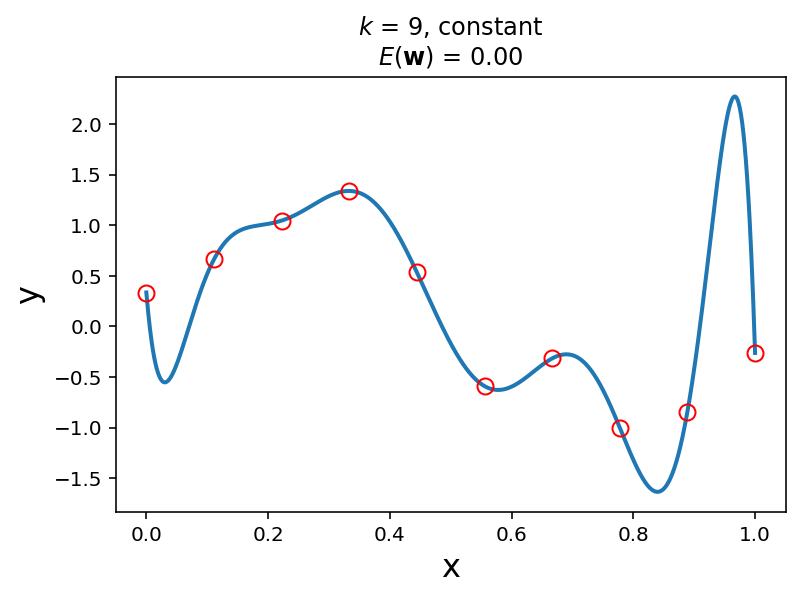

In [124]:
A_9 = np.column_stack([np.ones(N), x.T, (x.T)**2, (x.T)**3, (x.T)**4, (x.T)**5, (x.T)**6, (x.T)**7, (x.T)**8, (x.T)**9])
w_hat_9 = np.linalg.inv(A_9.T @ A_9) @ A_9.T @ y
cy = np.column_stack([np.ones(1000), cx.T, (cx.T)**2, (cx.T)**3, (cx.T)**4, (cx.T)**5, (cx.T)**6, (cx.T)**7, (cx.T)**8, (cx.T)**9]) @ w_hat_9
plt.plot(cx, cy, lw = 2, label = r'$k$ = 9')
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16)
plt.title(r'$k$ = 9, constant' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(0));

(This image was originally from <a class="external text" href="http://en.wikipedia.org">en.wikipedia</a>; description page is/was <a class="external text" href="http://en.wikipedia.org/w/index.php?title=Image%3ASnow-cholera-map-1.jpg">here</a>. Image copied from <a rel="nofollow" class="external free" href="http://matrix.msu.edu/~johnsnow/images/online_companion/chapter_images/fig12-5.jpg">http://matrix.msu.edu/~johnsnow/images/online_companion/chapter_images/fig12-5.jpg</a>), Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=2278605">https://commons.wikimedia.org/w/index.php?curid=2278605</a>

<center>
    
<img src="figs/L6-John_Snow_memorial_and_pub.png" alt="Figure" width="400px">
    
</center>

<a href="http://creativecommons.org/licenses/by-sa/2.0" title="Creative Commons Attribution-Share Alike 2.0">CC BY-SA 2.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=357998">https://commons.wikimedia.org/w/index.php?curid=357998</a>

## Clustering is Unsupervised Learning

Clustering is a very important way of discovering __structure__ in data.

It is so important because it is __common__ for data to show clusters.

* Locations where millionaires live
* The number of hours people work each week
* Demographics ("soccer moms", "bored retirees", "unemployed millenials", etc)


We can often simplify or compress our data if we recognize the existence of clusters.

Further, we can often interpret clusters by assigning them labels.

However, note that these categories or "labels" are assigned __after__ the fact.

And, we may __not__ be able to interpret clusters or assign them labels in some cases.

That is, clustering represents the first example we will see of __unsupervised__ learning.

__Supervised__ methods:  Data items have labels, and we want to learn a function that correctly assigns labels to new data items.

__Unsupervised__ methods:  Data items do not have labels, and we want to learn a function that extracts  important patterns from the data.

__Applications of Clustering:__

* Image Processing
    * Cluster images based on their visual content
    * Compress images based on color clusters
* Web Mining
    * Cluster groups of users based on webpage access patterns
    * Cluster web pages based on their content
* Bioinformatics
    * Cluster similar proteins together (by structure or function)
    * Cluster cell types (by gene activity)
* And many more ...

## The Clustering Problem

When we do clustering, what problem are we trying to solve?

We will answer this question informally at first. 

(But soon we will look at formal criteria!)

Informally, a __clustering__ is:
    
> a grouping of data objects, such that the objects within a group are similar (or near) to one another and dissimilar (or far) from the objects in other groups.

(keep in mind that if we use a distance function as a dissimilarity measure, then "far" implies "different")

<center>
    
<img src="figs/L06-clustering-1.png" alt="Figure" width="350px">
    
</center>

So we want our clustering algorithm to:
* <font color = "blue">minimize</font> intra-cluster distances
* <font color = "red">maximize</font> inter-cluster distances

Here are the basic questions we need to ask about clustering:
    
* What is the right kind of <font color = "blue">"similarity"</font> to use?
* What is a <font color="blue">"good" partition</font> of objects?
    * ie, how is the quality of a solution measured?
* <font color = "blue">How to find</font> a good partition?
    * are there efficient algorithms?  
    * are there algorithms that are guaranteed to find good clusters?

Now note that even with our more-formal discussion, the criteria for deciding on a "best" clustering can still be ambiguous.

<center>
    
<img src="figs/L06-clustering-2.png" alt="Figure" width="600px">
    
</center>

To accommodate the ambiguity here, one approach is to seek a __hierarchical__ clustering:

That is, as set of nested clusters organized in a tree.

We'll discuss hierarchical cluster in an upcoming lecture.

For today, we'll focus on __partitional__ clustering:  

in a partitional clustering, the points are divided into a set of __non-overlapping__ groups.

<center>
    
<img src="figs/L06-partitional-clustering.png" alt="Figure" width="600px">
    
</center>

In a partitional clustering:
* Each object belongs to __one__, and only one, cluster
* The set of clusters covers all the objects

We are going to assume for now that the number of clusters is given in advance.

We will denote the number of clusters as $k$.

## The $k$-means Problem

Now, we are ready to state our first formalization of the clustering problem.

We will assume that 
* data items are represented by points in $\mathbb{R}^d$.   (In other words, each data item has $d$ features.)
* $n$ points are given
* the number of clusters $k$ is given

__$k$-means Problem:__

Find $k$ points $c_1, \dots, c_k$ (called _centers_ or _means_) so that the cost

$$ \sum_{i=1}^n \min_j \ell_2^2(x_i, c_j) = \sum_{i=1}^n \min_j \Vert x_i-c_j\Vert^2_2 $$

is minimized.

__Equivalently:__ we can think in terms of the partition itself.

Consider the set $X = \{x_1, \dots, x_n\}$ where $x_i \in \mathbb{R}^n$.
    
Find $k$ points $c_1, \dots, c_k$ (called _centers_ or _means_) 

and partition $X$ into subsets $\{X_1, \dots, X_k\}$ by assigning each point $x_i$ in $X$ to its nearst cluster center,

so that the cost

$$ \sum_{i=1}^n \min_j \Vert x_i-c_j\Vert^2_2 = \sum_{j=1}^k \sum_{x \in X_j} \Vert x - c_j \Vert^2_2 $$

is minimized.

We now have a <font color="blue">formal</font> definition of a clustering.

This is not the only definition possible, but it is an intuitive and simple one.

How hard is it to solve this problem?

* $k=1$ and $k=n$ are easy special cases (why?)
* But, this problem is __NP-hard__ if the dimension of the data is at least 2
    * We don't expect that there is any exact, efficient algorithm in general 

__Nonetheless,__ there is a simple algorithm that works quite well in practice!

## The $k$-means Algorithm

There is a "classic" algorithm for this problem.

It was voted among the __top-10 algorithms__ in data mining!

It is such a good idea that it has been independently discovered multiple times.

It was first discovered by Lloyd in 1957, so it is often called Lloyd's algorithm.

It is called the "$k$-means algorithm"

(not to be confused with the $k$-means problem!)

<center>
    
<img src="figs/L06-top-ten-algorithms-cover.png" alt="Figure" width="300px">
    
</center>

The $k$-means algorithm:

1. Pick $k$ cluster centers $\{c_1, \dots, c_k\}$.  These can be chosen randomly, or by some other method.
2. For each $j$, define the cluster $X_j$ as the set of points in $X$ that are <font color="blue">closest to center</font> $c_k$.  
(Nearer to $c_k$ than to any other center.)
3. For each $j$, let $c_j$ be <font color="blue">the center of mass of cluster</font> $X_j$.  
(In other words, $c_j$ is the mean of the vectors in $X_j$.)
4. Repeat (ie, go to Step 2) until convergence.

Let's see this in practice:

<center>
    
<img src="figs/L06-kmeans-example.png" alt="Figure" width="600px">
    
</center>

## Limitations of $k$-means

As you can see, $k$-means can work very well.

However, we don't have any guarantees on the performance of $k$-means.

In particular, there are various settings in which $k$-means can fail to do a good job.

1. __$k$-means tries to find spherical clusters__.

Because each point is assigned to its closest center, the points in a cluster are implicitly assumed to be arranged in a sphere around the center.

<center>
    
<img src="figs/L06-kmeans-nonspherical-clusters.png" alt="Figure" width="600px">
    
</center>

2. __$k$-means tries to find equal-sized clusters.__

For the same reason, the sizes of clusters are implicitly assumed to be approximately equal.

<center>
    
<img src="figs/L06-kmeans-cluster-size.png" alt="Figure" width="600px">
    
</center>

3. __$k$-means is sensitive to the starting cluster centers.__

If the initial guess (Step 1) is a bad one, $k$-means may get "stuck" in a bad solution.


<center>
    
<img src="figs/L06-kmeans-bad-initialization.png" alt="Figure" width="600px">
    
</center>

### Choosing a Good Initialization

How can we avoid the kind of bad initialization we just saw?

A good strategy is to pick points that are distant to each other.

This strategy is called "$k$-means++".  

It works very well in practice, and the `scikit-learn` implementation uses it by default.

(We will explore it in the next lecture.)

### Choosing the right $k$

Generally, we would say that, given some $k$, the $k$-means algorithm "learns" the cluster centers -- that is, the parameters of the model.

But we have not yet considered how to choose the right number of clusters.

That's typically __not__ something one knows in advance.

As an aside:
* This parameter ($k$) is the first example we have seen of a __hyperparameter__.
* A hyperparameter is a parameter that must be set before the model parameters can be learned.

Our basic strategy will be to
* Iterate through different $k$ and use some criterion to decide which $k$ is most appropriate.
* We will discuss this more in the next lecture.

### Feature Scaling

Finally, given the tendency of $k$-means to look for spherical clusters, we should consider the scales of the various features.

In fact, in general when constructing or selecting a distance metric, one needs to think carefully about the scale of the features being used.

For example, consider the case where we are clustering people based on their age, income, and gender.

We might use age in years, income in dollars, and assign gender to the values $\{0, 1\}$.

Thus, the following records:

* Joe Smith, age 27, income USD 75,000, male
* Eve Jones, age 45, income USD 42,000, female

Would be encoded in feature space as:

$$\begin{bmatrix}27\\75000\\0\end{bmatrix},\begin{bmatrix}45\\42000\\1\end{bmatrix} $$

What would happen if we used Euclidean distance as our dissimilarity metric in this feature space?

(This is what $k$-means uses.)

Clearly, the influence of income would dominate the other two features.  For example, a difference of gender is about as significant as a difference of one dollar of yearly income.

We are unlikely to expose gender-based differences if we cluster using this representation.

The most common way to handle this is __feature scaling.__

The basic idea is to rescale each feature separately, so that its range of values is about the same as all other features.

For example, one may choose to:
    
* shift each feature independently by subtracting the mean over all observed values
    * This means that each feature is now centered on zero
* then rescale each feature so that the standard deviation overall observed values is 1.
    * This means that the feature will have about the same range of values as all the others.

For example, let's work with Bortkiewicz's famous horse-kick data:

In [6]:
# source: http://www.randomservices.org/random/data/HorseKicks.html
import pandas as pd
df = pd.read_table('data/HorseKicks.txt',index_col='Year',dtype='float')
counts = df.sum(axis=1)
counts

Year
1875.0     3.0
1876.0     5.0
1877.0     7.0
1878.0     9.0
1879.0    10.0
1880.0    18.0
1881.0     6.0
1882.0    14.0
1883.0    11.0
1884.0     9.0
1885.0     5.0
1886.0    11.0
1887.0    15.0
1888.0     6.0
1889.0    11.0
1890.0    17.0
1891.0    12.0
1892.0    15.0
1893.0     8.0
1894.0     4.0
dtype: float64

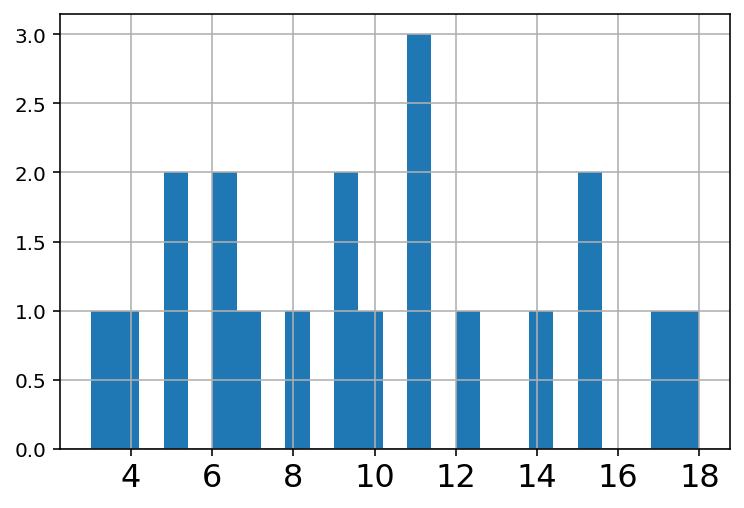

In [7]:
counts.hist(bins=25,xlabelsize=16);

In [8]:
counts.mean()

9.8

To standardize to zero mean and unit standard deviation, we can use tools from the `scikit-learn` library.

(We will discuss scikit-learn more in upcoming lectures.)

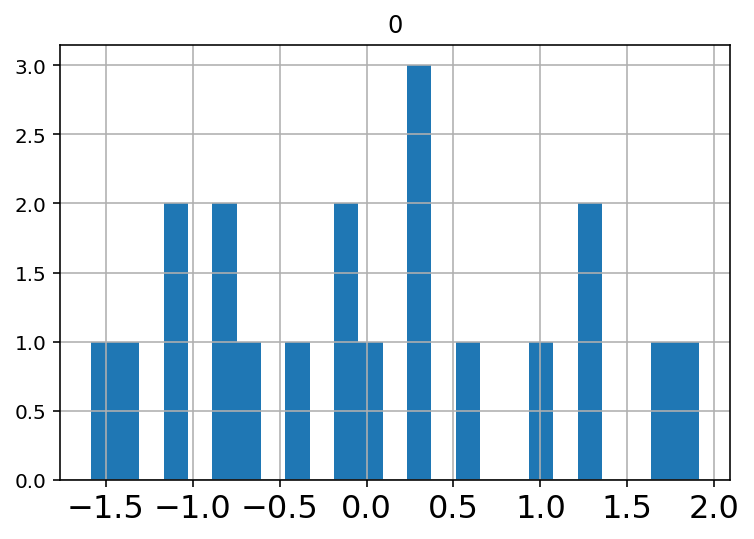

In [9]:
from sklearn import preprocessing
counts_scaled = pd.DataFrame(preprocessing.scale(counts))
counts_scaled.hist(bins=25,xlabelsize=16);

In [10]:
counts_scaled.mean().values

array([-1.33226763e-16])

Notice that values that used to be zero have now become negative.

In some situations it may not be sensible to change zeros into something else.  It may make more sense to map all values into a fixed range, for example $[0, 1]$.

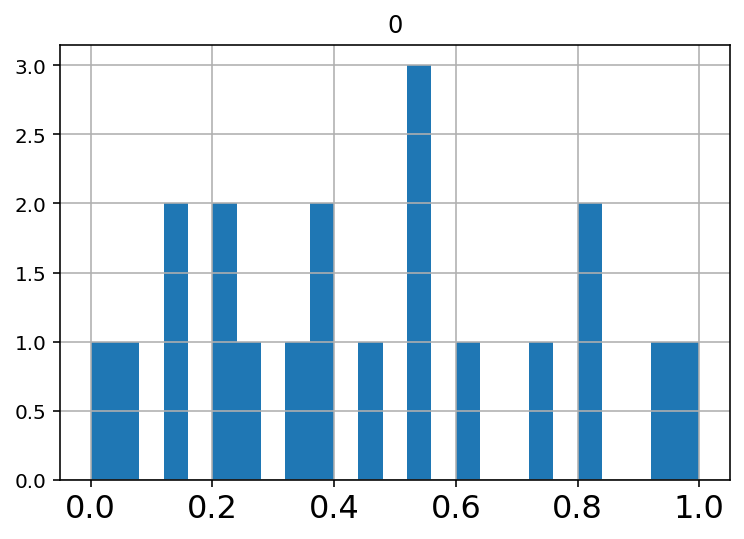

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
counts_minmax = min_max_scaler.fit_transform(counts.values.reshape(-1,1))
counts_minmax = pd.DataFrame(counts_minmax)
counts_minmax.hist(bins=25,xlabelsize=16);

__Example Output from k-means.__

Here is a simple example of how $k$-means can be used for data compression.

Consider the following image.  Each color in the image is represented by an integer.  Typically we might use 24 bits for each integer (8 bits for R, G, and B).


<center>
    
<img src="figs/L6-annie19980405.jpg" alt="Figure" width="350px">
    
</center>

Now cluster the pixels by their color value, and replace each pixel by its cluster center.

Because there are a smaller number of colors used, we can use fewer bits for each pixel.

Here, we use 4 bits (16 colors) for a compression ratio around 6$\times$.

<center>
    
<img src="figs/L6-annie_016.png" alt="Figure" width="500px">
    
</center>

Here, we use 3 bits (8 colors) for a compression ratio around 8$\times$.

<center>
    
<img src="figs/L6-annie_008.png" alt="Figure" width="500px">
    
</center>

Here, we use 2 bits (4 colors) for a compression ratio around 12$\times$.

<center>
    
<img src="figs/L6-annie_004.png" alt="Figure" width="500px">
    
</center>

Finally, we use 1 bit (2 colors) for a compression ratio around 24$\times$.

<center>
    
<img src="figs/L6-annie_002.png" alt="Figure" width="500px">
    
</center>